In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
def pt_module_parameters(module):
    """ Retorna la cantidad de parametros del modulo pytorch """
    pp=0
    for p in list(module.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

# Create dataset and dataloader
class CoordinateDataset(Dataset):
    def __init__(self, data_dir):
        self.data = pd.read_csv(data_dir)
        self.x, self.y = self.__processing()

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] # Se regresa un registro de datos junto con su etiqueta

    def __len__(self):
        return len(self.data)

    def __processing(self):
        i, o = self.data[['x', 'y']].to_numpy(), self.data[['z', 'r', 'g', 'b']].to_numpy()
        return torch.from_numpy(i).float(), torch.from_numpy(o).float()  
    
# Rotary Position Embedding (RoPE) module
class RoPE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        inv_freq = torch.logspace(0, 3, dim//2) #Valores que multiplican al angulo van desde 1 a 1000 en escala logaritmica
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        # x shape: (batch_size, 2) containing (x, y) coordinates
        x_coords = x[:, 0]
        y_coords = x[:, 1]
        
        x_embed = self._embed_single(x_coords)
        y_embed = self._embed_single(y_coords)
        return torch.cat([x_embed, y_embed], dim=1)

    def _embed_single(self, pos):
        # pos shape: (batch_size,)
        angles = pos.unsqueeze(-1) * self.inv_freq.unsqueeze(0)
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        
        # Interleave sin and cos values
        embed = torch.stack([sin, cos], dim=-1)
        return embed.view(embed.size(0), -1)

# TODO modelo con dos salidas   

# Neural network architecture
class ColorNetRope(nn.Module):
    def __init__(self, rope_dim, linear_dim):
        super().__init__()
        self.rope = RoPE(rope_dim)
        self.layers = nn.Sequential(
            nn.Linear(2 * rope_dim, linear_dim),
            nn.GELU(), 
            nn.Linear(linear_dim, linear_dim),
            nn.GELU(),
            nn.Linear(linear_dim, linear_dim),
            nn.GELU()            
        )

        self.output_h = nn.Sequential(
            nn.Linear(linear_dim, linear_dim),
            nn.GELU(),
            nn.Linear(linear_dim, 1),
            nn.Sigmoid()            
        )
        
        self.output_rbg = nn.Sequential(
            nn.Linear(linear_dim, linear_dim),
            nn.GELU(),
            nn.Linear(linear_dim, 3),
            nn.Sigmoid()            
        )

    def forward(self, x):
        x = self.rope(x)
        x = self.layers(x)
        o1 = self.output_h(x)
        o2 = self.output_rbg(x)

        return o1, o2
    

In [3]:
# Configuration
EPOCHS = 10
BATCH_SIZE = 2048
LEARNING_RATE = 0.001
ROPE_DIM = 64   # Dimension for each coordinate's RoPE embedding
LINEAR_DIM = 256 # Dimension for each linear layer

POOL_NAME = 'RBS'
PROJECT_NAME = 'pozas_130125_100_10_120'
PATH_DATASET = f'data/{PROJECT_NAME}/{POOL_NAME}.csv'

In [4]:
dataset = CoordinateDataset(PATH_DATASET)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False) 

In [5]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ColorNet().to(device)
model = ColorNetRope(ROPE_DIM, LINEAR_DIM).to(device)
criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE*0.1)

print(f"Model Parameters: {pt_module_parameters(model)}")

Model Parameters: 297220


In [6]:
# Training loop
train_loss = []
for epoch in range(EPOCHS):
    count_batches = 0
    epoch_loss = 0.0
    epoch_loss_1 = 0.0
    epoch_loss_2 = 0.0

    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        h, rgb = model(inputs)
        loss1 = criterion(h, targets[:,0:1])
        loss2 = criterion(rgb, targets[:,1:])
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        epoch_loss_1 += loss1.item()
        epoch_loss_2 += loss2.item()
        epoch_loss += loss.item() 
        count_batches += 1
        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
        
    scheduler.step()
    epoch_loss /= count_batches
    epoch_loss_1 /= count_batches
    epoch_loss_2 /= count_batches
    
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f} Loss1: {epoch_loss_1:.6f} Loss2: {epoch_loss_2:.6f} LR: {scheduler.get_last_lr()[0]:.6f}')

Epoch 1/10 - Loss: 0.010811 Loss1: 0.002914 Loss2: 0.007898 LR: 0.000978


Epoch 2/10 - Loss: 0.008415 Loss1: 0.002407 Loss2: 0.006009 LR: 0.000914


Epoch 3/10 - Loss: 0.007146 Loss1: 0.002278 Loss2: 0.004869 LR: 0.000815


Epoch 4/10 - Loss: 0.006441 Loss1: 0.002182 Loss2: 0.004259 LR: 0.000689


Epoch 5/10 - Loss: 0.005932 Loss1: 0.002161 Loss2: 0.003771 LR: 0.000550


Epoch 6/10 - Loss: 0.005455 Loss1: 0.002072 Loss2: 0.003383 LR: 0.000411


Epoch 7/10 - Loss: 0.005031 Loss1: 0.002020 Loss2: 0.003011 LR: 0.000285


Epoch 8/10 - Loss: 0.004742 Loss1: 0.001984 Loss2: 0.002758 LR: 0.000186


Epoch 9/10 - Loss: 0.004511 Loss1: 0.001946 Loss2: 0.002565 LR: 0.000122


Epoch 10/10 - Loss: 0.004383 Loss1: 0.001922 Loss2: 0.002461 LR: 0.000100


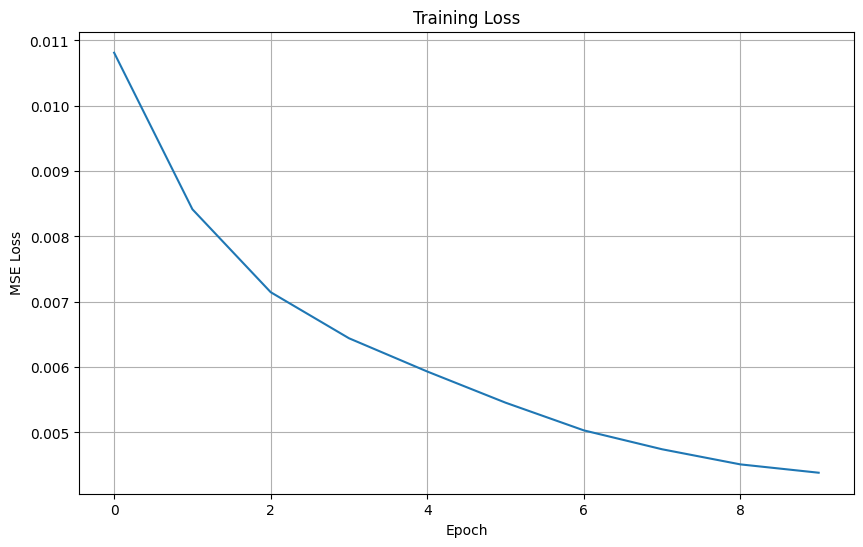

In [7]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [8]:
torch.save(model.state_dict(), f'data/{PROJECT_NAME}/{POOL_NAME}.pth')

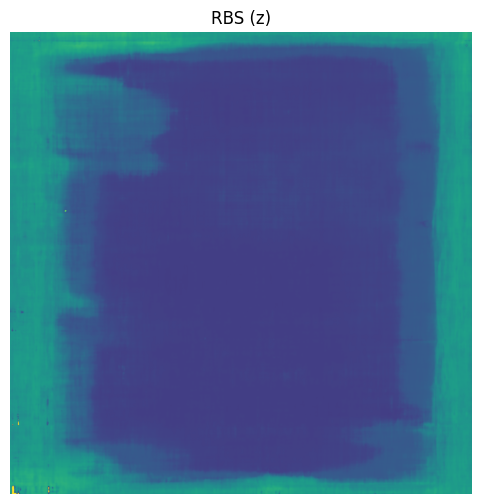

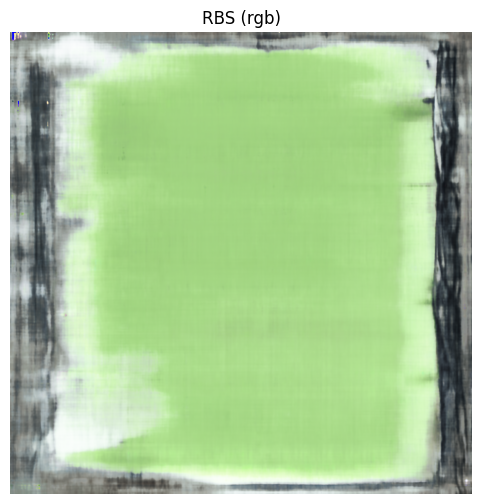

In [ ]:
import numpy as np

x = np.linspace(0, 1, 2048)
y = np.linspace(0, 1, 2048)
x, y = np.meshgrid(x, y)

model = model.to('cpu')
input = np.c_[x.ravel(), y.ravel()] 
input = torch.tensor(input, dtype=torch.float32).to('cpu')

h, rgb = model(input)
h  = h.detach().numpy().reshape(x.shape) 
rgb = rgb.detach().numpy().reshape(x.shape + (3,)) 

#plot z 
plt.figure(figsize=(10, 6))
plt.imshow(h, extent=(x.min(), x.max(), y.min(), y.max()))
#plt.contourf(x, y, h, cmap='jet')
#plt.colorbar()
plt.title(f'{POOL_NAME} (z)')
plt.axis('off')
#plt.savefig(f'RBS_z.png', bbox_inches='tight', dpi=300)
plt.show()

# Plot de la superficie rgb
plt.figure(figsize=(10, 6))
plt.imshow(rgb, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
plt.title(f'{POOL_NAME} (rgb)'), 
plt.axis('off')

#plt.savefig(f'RBS_rbg.png', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
import cv2
import os
from PIL import Image

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = z.astype(np.float32) 
cv2.imwrite(f'data/{PROJECT_NAME}/{POOL_NAME}_z_model2.exr', z_save)

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'data/{PROJECT_NAME}/{POOL_NAME}_z_model2.tiff')

rgb_save = rgb * 255
rgb_image = Image.fromarray(rgb_save.astype(np.uint8))
rgb_image.save(f'data/{PROJECT_NAME}/{POOL_NAME}_rgb_model2.png')

# por poza 
# nombre de la poza
# fecha
# altura 
# frecuencia
# lat, log
# x_min, x_max
# y_min, y_max
# z_min, z_max
# nivel de agua z_water - Defecto valor para cuando no hay agua valor -inf
# img -> rgb y altura




NameError: name 'z' is not defined